# Setup

In [1]:
# General libraries
import pandas as pd
import numpy as np

# Utilities
from pathlib import Path
import psutil
import gc
import os

# Cuda
import torch

In [2]:
# Warnings
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress the specific PerformanceWarning
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Pd options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [3]:
# Get the number of available CPUs
num_cpus = os.cpu_count()

# Show
print(num_cpus)

12


In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


# Directory

In [5]:
# Set the right directory
current_path = Path.cwd()
if current_path.name in ['notebooks', 'src']:
    os.chdir('..')
    print(f"Moved up from {current_path.name} to: {os.getcwd()}")
else:
    print(f"Already in project directory: {os.getcwd()}")

Moved up from notebooks to: /Users/ignasipascual/GitHub/Forecaster


# Assets

## Import assets

In [6]:
# Import assets
from utils.forecaster import Forecaster
from utils.evaluator import Evaluator
from utils.auxiliar import *

# Load data

In [7]:
# Load from data folder
file_name = f'data/df_backtesting.csv'

# Load the CSV into a DataFrame
df_input = pd.read_csv(file_name)

# Show
df_input.head()

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,sales_units,inventory_units,filled_sales_units,filled_inventory_units,cutoff,sample,feature_reporterhq_id,feature_product_number,feature_prod_category,feature_specs,feature_display_size,feature_segment,feature_periods,feature_periods_expanding,feature_periods_sqrt,feature_year,feature_quarter,feature_month,feature_week,feature_weeks_until_next_end_of_quarter,feature_weeks_until_end_of_year,feature_months_until_next_end_of_quarter,feature_months_until_end_of_year,filled_sales_units_ma_4,filled_sales_units_ma_13,filled_inventory_units_ma_4,filled_inventory_units_ma_13,filled_sales_units_min_4,filled_sales_units_max_4,filled_sales_units_min_13,filled_sales_units_max_13,filled_inventory_units_min_4,filled_inventory_units_max_4,filled_inventory_units_min_13,filled_inventory_units_max_13,feature_filled_sales_units_lag_13,feature_filled_sales_units_lag_52,feature_filled_inventory_units_lag_13,feature_filled_inventory_units_lag_52,feature_filled_sales_units_ma_4_lag_13,feature_filled_sales_units_ma_4_lag_52,feature_filled_sales_units_ma_13_lag_13,feature_filled_sales_units_ma_13_lag_52,feature_filled_inventory_units_ma_4_lag_13,feature_filled_inventory_units_ma_4_lag_52,feature_filled_inventory_units_ma_13_lag_13,feature_filled_inventory_units_ma_13_lag_52,feature_filled_sales_units_min_4_lag_13,feature_filled_sales_units_min_4_lag_52,feature_filled_sales_units_max_4_lag_13,feature_filled_sales_units_max_4_lag_52,feature_filled_sales_units_min_13_lag_13,feature_filled_sales_units_min_13_lag_52,feature_filled_sales_units_max_13_lag_13,feature_filled_sales_units_max_13_lag_52,feature_filled_inventory_units_min_4_lag_13,feature_filled_inventory_units_min_4_lag_52,feature_filled_inventory_units_max_4_lag_13,feature_filled_inventory_units_max_4_lag_52,feature_filled_inventory_units_min_13_lag_13,feature_filled_inventory_units_min_13_lag_52,feature_filled_inventory_units_max_13_lag_13,feature_filled_inventory_units_max_13_lag_52,feature_filled_inventory_units_cov,feature_distinct_product_number_reporterhq_id,feature_distinct_product_number_cutoff,feature_filled_sales_units_cluster,feature_filled_inventory_units_cluster,feature_filled_sales_units_history_cluster,feature_filled_inventory_units_history_cluster,feature_intermittence_filled_sales_units_cluster,feature_intermittence_filled_inventory_units_cluster,train_weight,fcst_lag,feature_baseline_filled_sales_units_ma_13,feature_baseline_filled_inventory_units_ma_13,baseline_filled_sales_units_ma_13,baseline_filled_inventory_units_ma_13,baseline_filled_sales_units_lgbm,feature_baseline_filled_sales_units_lgbm
0,6,119427,Goku,139248,14.0,Core,2023-01-07,NaN,0.0,NaN,0.0,2023-02-04,train,9,20,5,40,5,0,0.0,0.0,0.0,2023,1,1,1,11.86,51.14,2.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,0,1,0,1,1,3,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN
1,6,119427,Goku,139248,14.0,Core,2023-01-07,NaN,0.0,NaN,0.0,2023-03-04,train,9,20,5,40,5,0,0.0,0.0,0.0,2023,1,1,1,11.86,51.14,2.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,0,1,0,1,1,3,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN
2,6,119427,Goku,139248,14.0,Core,2023-01-07,NaN,0.0,NaN,0.0,2023-04-01,train,9,20,5,40,5,0,0.0,0.0,0.0,2023,1,1,1,11.86,51.14,2.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,0,1,0,1,1,3,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN
3,6,119427,Goku,139248,14.0,Core,2023-01-07,NaN,0.0,NaN,0.0,2023-05-06,train,9,20,5,40,5,0,0.0,0.0,0.0,2023,1,1,1,11.86,51.14,2.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Statistics

In [8]:
# Find duplicate column names
duplicate_columns = df_input.columns[df_input.columns.duplicated()].tolist()

# Show
print("Duplicate column names:", duplicate_columns)

Duplicate column names: []


In [9]:
# Check if any column is completely filled with NaN values
na_columns = df_input.columns[df_input.isna().all()].tolist()

# Show
print("Columns full of NaN values:", na_columns)

Columns full of NaN values: []


In [10]:
# Show data types
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107104 entries, 0 to 107103
Data columns (total 87 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   reporterhq_id                                         107104 non-null  int64  
 1   product_number                                        107104 non-null  int64  
 2   prod_category                                         107104 non-null  object 
 3   specs                                                 107104 non-null  int64  
 4   display_size                                          107104 non-null  float64
 5   segment                                               107104 non-null  object 
 6   date                                                  107104 non-null  object 
 7   sales_units                                           98564 non-null   float64
 8   inventory_units                             

# Forecasting model

## Features

In [11]:
# Automatically find all feature columns containing 'feature' in their names
features = [col for col in df_input.columns if "feature" in col]

# Create default trainining group
df_input['training_group'] = 1

# Show
features

['feature_reporterhq_id',
 'feature_product_number',
 'feature_prod_category',
 'feature_specs',
 'feature_display_size',
 'feature_segment',
 'feature_periods',
 'feature_periods_expanding',
 'feature_periods_sqrt',
 'feature_year',
 'feature_quarter',
 'feature_month',
 'feature_week',
 'feature_weeks_until_next_end_of_quarter',
 'feature_weeks_until_end_of_year',
 'feature_months_until_next_end_of_quarter',
 'feature_months_until_end_of_year',
 'feature_filled_sales_units_lag_13',
 'feature_filled_sales_units_lag_52',
 'feature_filled_inventory_units_lag_13',
 'feature_filled_inventory_units_lag_52',
 'feature_filled_sales_units_ma_4_lag_13',
 'feature_filled_sales_units_ma_4_lag_52',
 'feature_filled_sales_units_ma_13_lag_13',
 'feature_filled_sales_units_ma_13_lag_52',
 'feature_filled_inventory_units_ma_4_lag_13',
 'feature_filled_inventory_units_ma_4_lag_52',
 'feature_filled_inventory_units_ma_13_lag_13',
 'feature_filled_inventory_units_ma_13_lag_52',
 'feature_filled_sales_un

In [12]:
# Number of features
print("Number of features:", len(features))

Number of features: 57


## Hyperparameters

In [13]:
# Define parameter dictionary
hyperparam_dictionary = {
    'LGBM': {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000, 2000],
        'num_leaves': [15, 31, 64],
        'max_depth': [4, 8, 12],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0.0, 0.1, 0.5],
        'reg_lambda': [0.0, 0.1, 0.5]
    }
}

# Calculate the number of combinations
num_combinations = (
    len(hyperparam_dictionary['LGBM']['learning_rate']) *
    len(hyperparam_dictionary['LGBM']['n_estimators']) *
    len(hyperparam_dictionary['LGBM']['num_leaves']) *
    len(hyperparam_dictionary['LGBM']['max_depth']) *
    len(hyperparam_dictionary['LGBM']['subsample']) *
    len(hyperparam_dictionary['LGBM']['colsample_bytree']) *
    len(hyperparam_dictionary['LGBM']['reg_alpha']) *
    len(hyperparam_dictionary['LGBM']['reg_lambda'])
)

# Print the number of potential combinations
print(f"Number of potential combinations for Grid Search: {num_combinations:,}")

Number of potential combinations for Grid Search: 6,561


## Configuration

In [ ]:
# Parameters
group_cols = ['reporterhq_id', 'product_number']
training_group = 'training_group'
target_col = 'filled_inventory_units'
model = 'LGBM'
tune_hyperparameters = False
search_method = 'halving'
default_params = None
param_distributions = hyperparam_dictionary
scoring_metric = 'neg_root_mean_squared_error'
n_iter = 50
best_features = False
n_best_features = 25
use_weights = True

# Outliers
remove_outliers = True
outlier_column = 'filled_inventory_units'
lower_quantile = 0.025
upper_quantile = 0.975
ts_decomposition = False

# Guardrail
baseline_col = 'baseline_filled_inventory_units_ma_13'
use_guardrail = True
guardrail_limit = 2.5

# Parallel
use_parallel = False
num_cpus = 5

: 

## Run Predictor

In [ ]:
%%time
# Initialize the Forecaster class with df_input
forecaster = Forecaster(df_input)

# Call the function
df_with_preds = forecaster.run_backtesting(
    group_cols,
    features,
    default_params,
    training_group,
    target_col,
    model,
    tune_hyperparameters,
    search_method,
    param_distributions,
    scoring_metric,
    n_iter,
    best_features,
    n_best_features,
    remove_outliers,
    outlier_column,
    lower_quantile,
    upper_quantile,
    ts_decomposition,
    baseline_col,
    use_guardrail,
    guardrail_limit,
    use_weights,
    use_parallel,
    num_cpus
)

Starting backtesting
User did not provide parameter dictionary, using internal method


## Optimization

In [ ]:
# If hyperparameter tuning retrieve best combination
if tune_hyperparameters:

  # Retrieve and print the best hyperparameters for each cutoff
  best_hyperparams = forecaster.get_best_hyperparams()
  print("Best Hyperparameters for each cutoff:")

  # Show
  for cutoff, params in best_hyperparams.items():
      print(f"Cutoff {cutoff}: {params}")

Best Hyperparameters for each cutoff:


## Guardrail

In [ ]:
# If guardrail is activated
if use_guardrail:
  # Assuming 'df_with_preds' is the DataFrame
  group_cols = ['reporterhq_id', 'product_number', 'cutoff']

  # Group by the specified columns and check for at least one True in each group
  guardrail_groups =  df_with_preds.groupby(group_cols)['guardrail'].any().reset_index()

  # Calculate the total number of groups
  total_groups = guardrail_groups.shape[0]

  # Count the number of groups where guardrail is True
  true_guardrail_groups_count = guardrail_groups['guardrail'].sum()

  # Calculate the percentage of groups with guardrail == True
  percentage_guardrail_true = (true_guardrail_groups_count / total_groups) * 100

  # Show
  print(f"Percentage of groups where guardrail is True: {percentage_guardrail_true:.2f}%")

NameError: name 'df_with_preds' is not defined

# Evaluate results

## Feature importance

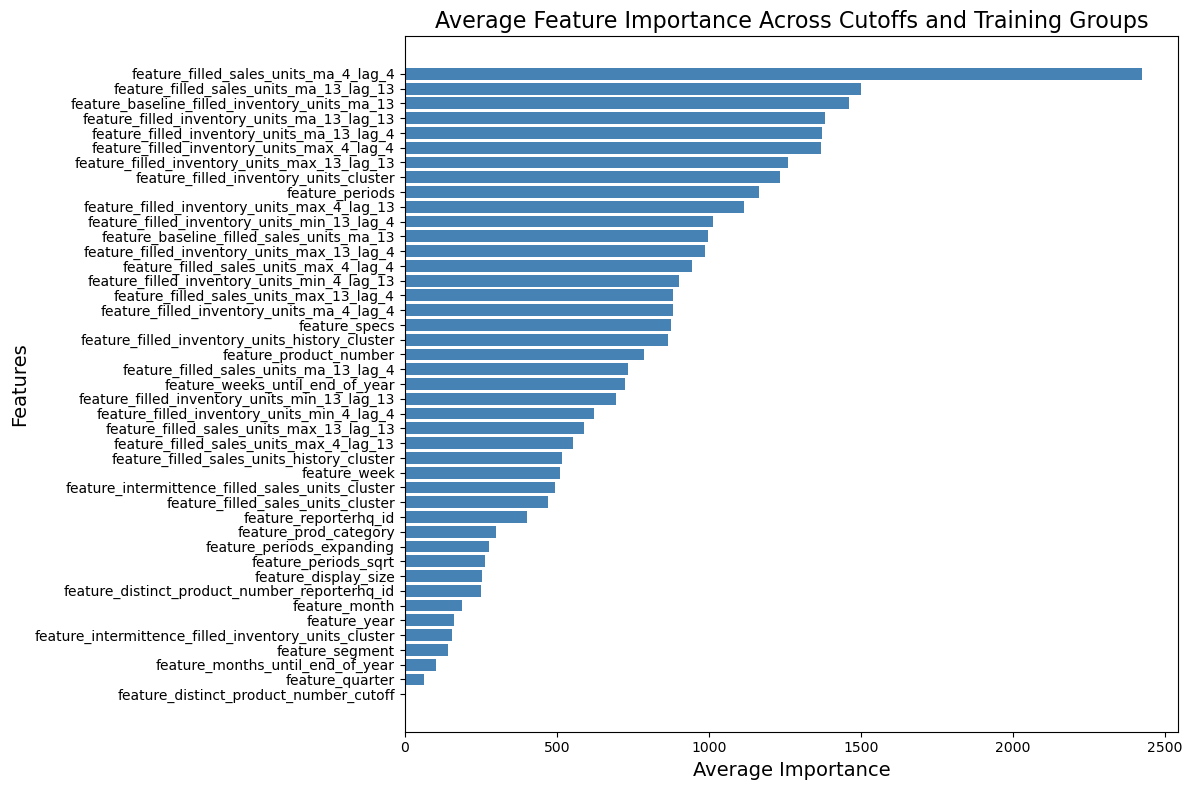

In [ ]:
# Plot the average feature importance across all cutoffs
forecaster.plot_feature_importance()

## Run evaluator

In [ ]:
# Params
actuals_col = 'inventory_units'
baseline_col = 'baseline_filled_inventory_units_ma_13'
preds_col = ['prediction']

# Initialize the Evaluator class
evaluator = Evaluator(df_with_preds, actuals_col, baseline_col, preds_col)

# Call the function
metric_table = evaluator.create_metric_table()

# Show
metric_table

,RMSE,MAE,MAPE,WMAPE,Custom Metric
baseline_filled_inventory_units_ma_13,59.57,44.33,209.89,62.13,63.46
prediction,50.37,37.76,184.90,52.93,55.12


## Lag metrics

In [ ]:
# Params
metric_name = 'RMSE'
group_col = 'fcst_lag'
group_filter = range(1,14)

# Call the function
lag_metrics = evaluator.calculate_grouped_metric(metric_name, group_col, group_filter)

# Show
lag_metrics

fcst_lag,1,2,3,4,5,6,7,8,9,10,11,12,13
Baseline,54.613037,42.999217,37.050326,31.431885,20.540000,56.848724,58.115914,58.304930,53.297711,26.492863,56.358941,62.496332,76.000526
prediction,42.718168,31.060920,32.624363,37.067039,14.227994,45.325548,42.144652,41.399061,35.303161,24.542314,44.384479,40.383350,41.998028


# Plot predictions


In [ ]:
# Get the max cutoff
max_cutoff = df_with_preds['cutoff'].max()

# Filter the DataFrame where cutoff is equal to the max cutoff
df_filtered = df_with_preds[df_with_preds['cutoff'] == max_cutoff]

# Show
df_filtered.head()

,reporterhq_id,product_number,prod_category,specs,display_size,segment,date,year_week,sales_units,inventory_units,filled_sales_units,filled_inventory_units,cutoff,sample,feature_reporterhq_id,feature_product_number,feature_prod_category,feature_specs,feature_display_size,feature_segment,feature_periods,feature_periods_expanding,feature_periods_sqrt,feature_year,feature_quarter,feature_month,feature_week,feature_weeks_until_next_end_of_quarter,feature_weeks_until_end_of_year,feature_months_until_next_end_of_quarter,feature_months_until_end_of_year,filled_sales_units_ma_4,filled_sales_units_ma_13,filled_inventory_units_ma_4,filled_inventory_units_ma_13,filled_sales_units_min_4,filled_sales_units_max_4,filled_sales_units_min_13,filled_sales_units_max_13,filled_inventory_units_min_4,filled_inventory_units_max_4,filled_inventory_units_min_13,filled_inventory_units_max_13,feature_filled_sales_units_lag_4,feature_filled_sales_units_lag_13,feature_filled_sales_units_lag_52,feature_filled_inventory_units_lag_4,feature_filled_inventory_units_lag_13,feature_filled_inventory_units_lag_52,feature_filled_sales_units_ma_4_lag_4,feature_filled_sales_units_ma_4_lag_13,feature_filled_sales_units_ma_4_lag_52,feature_filled_sales_units_ma_13_lag_4,feature_filled_sales_units_ma_13_lag_13,feature_filled_sales_units_ma_13_lag_52,feature_filled_inventory_units_ma_4_lag_4,feature_filled_inventory_units_ma_4_lag_13,feature_filled_inventory_units_ma_4_lag_52,feature_filled_inventory_units_ma_13_lag_4,feature_filled_inventory_units_ma_13_lag_13,feature_filled_inventory_units_ma_13_lag_52,feature_filled_sales_units_min_4_lag_4,feature_filled_sales_units_min_4_lag_13,feature_filled_sales_units_min_4_lag_52,feature_filled_sales_units_max_4_lag_4,feature_filled_sales_units_max_4_lag_13,feature_filled_sales_units_max_4_lag_52,feature_filled_sales_units_min_13_lag_4,feature_filled_sales_units_min_13_lag_13,feature_filled_sales_units_min_13_lag_52,feature_filled_sales_units_max_13_lag_4,feature_filled_sales_units_max_13_lag_13,feature_filled_sales_units_max_13_lag_52,feature_filled_inventory_units_min_4_lag_4,feature_filled_inventory_units_min_4_lag_13,feature_filled_inventory_units_min_4_lag_52,feature_filled_inventory_units_max_4_lag_4,feature_filled_inventory_units_max_4_lag_13,feature_filled_inventory_units_max_4_lag_52,feature_filled_inventory_units_min_13_lag_4,feature_filled_inventory_units_min_13_lag_13,feature_filled_inventory_units_min_13_lag_52,feature_filled_inventory_units_max_13_lag_4,feature_filled_inventory_units_max_13_lag_13,feature_filled_inventory_units_max_13_lag_52,feature_filled_inventory_units_cov,feature_distinct_product_number_reporterhq_id,feature_distinct_product_number_cutoff,feature_filled_sales_units_cluster,feature_filled_inventory_units_cluster,feature_filled_sales_units_history_cluster,feature_filled_inventory_units_history_cluster,feature_intermittence_filled_sales_units_cluster,feature_intermittence_filled_inventory_units_cluster,train_weight,fcst_lag,feature_baseline_filled_sales_units_ma_13,feature_baseline_filled_inventory_units_ma_13,baseline_filled_sales_units_ma_13,baseline_filled_inventory_units_ma_13,baseline_filled_sales_units_lgbm,feature_baseline_filled_sales_units_lgbm,training_group,guardrail,prediction
75414,6,119427,Goku,139248,14.0,Core,2023-01-07,202301.0,NaN,0.0,NaN,0.0,2023-05-06,train,9,20,5,40,5,0,0.0,0.00,0.00,2023,1,1,1,11.86,51.14,2.0,11.0,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,5,0,1,0,1,1,3,NaN,5,NaN,0.00,NaN,NaN,NaN,NaN,1,False,NaN
75415,24,233919,Clover,106370,15.6,Core,2019-04-27,201917.0,1.0,110.0,1.0,110.0,2023-05-06,train,3,137,2,7,6,0,1.0,1.00,1.00,2019,2,4,17,9.14,35.43,2.0,8.0,1.00,1.00,110.00,110.00,1.0,1.0,1.0,1.0,110.0,110.0,110.0,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
# Params
baseline_col = 'baseline_filled_inventory_units_ma_13'
target_col = 'inventory_units'
top_n_plots = 6

## Plot by Reporter

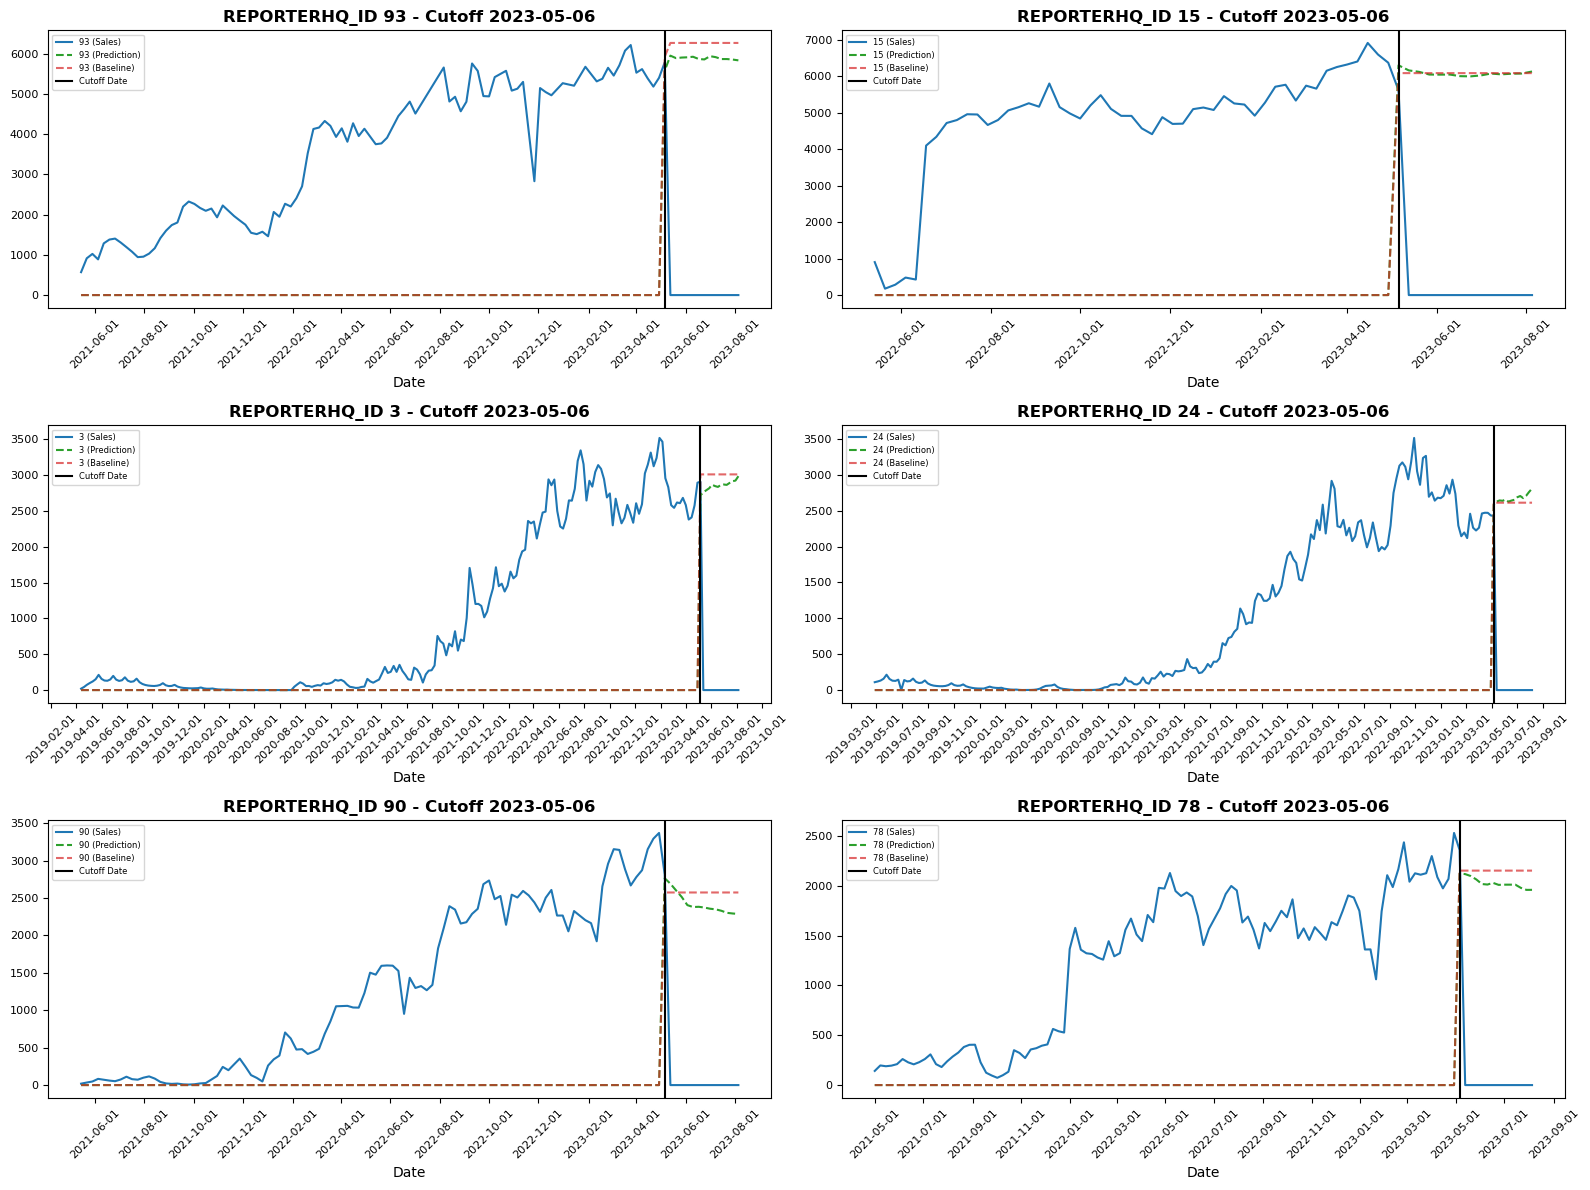

In [ ]:
# Plot by client
process_and_plot(
    df_filtered,
    group_col='reporterhq_id',
    baseline_col=baseline_col,
    target_col=target_col,
    top_n=top_n_plots,
    title='Top Reporter Target vs Baseline vs Prediction'
)

## Plot by Product

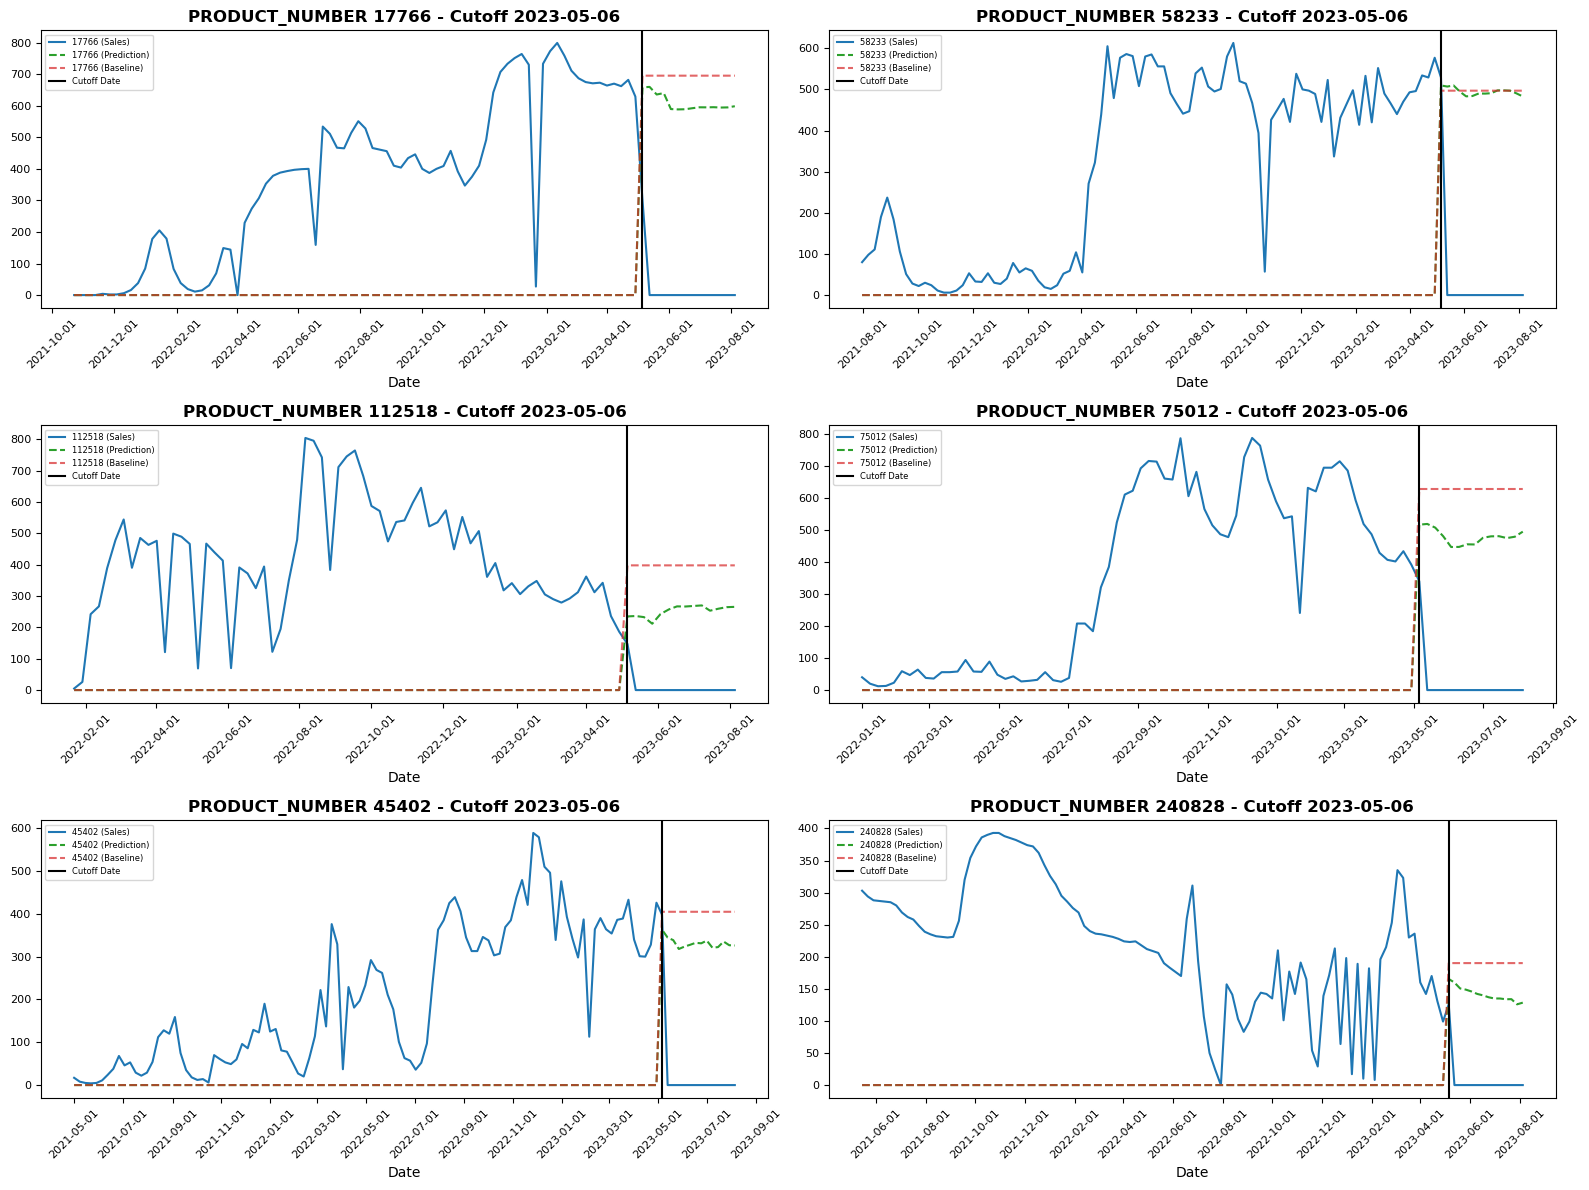

In [ ]:
# Plot by product
process_and_plot(
    df_filtered,
    group_col='product_number',
    baseline_col=baseline_col,
    target_col=target_col,
    top_n=top_n_plots,
    title='Top Products Target vs Baseline vs Prediction'
)

# Save output

In [ ]:
# Create the filename with the phase appended
file_name = f'Data/df_lightgbm_preds.csv'

# Write the dataframe to the CSV file
df_with_preds.to_csv(file_name, index=False)

# Clean

In [ ]:
# Garbage collection
gc.collect()

51632